In [1]:
# Imports
import pandas as pd
import spacy
import re
import torch
from transformers import GPT2Tokenizer, GPT2Model, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/LLM_thesis/filtered_df.parquet'
filtered_df = pd.read_parquet(file_path)

#### Embedding Analysis for GPT-2 (baseline)

#### Creating a balanced subset for embedding analysis

In [4]:
# Takes a subset of 5 sentences that contain gendered terms per category to ensure a balanced representation
balanced_sample = []

for cat in sorted(filtered_df["stereotype"].unique()):
    group = filtered_df[filtered_df["stereotype"] == cat]

    # Filters for gendered terms
    gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]

    if len(gendered) >= 5:
        sample = gendered.sample(n=5, random_state=42)
        balanced_sample.append(sample)
    else:
        print(f"⚠️ Not enough gendered examples in category {cat}: only {len(gendered)} found")

final_subset_df = pd.concat(balanced_sample).reset_index(drop=True)
print(f"Final balanced subset: {len(final_subset_df)} sentences")

Final balanced subset: 80 sentences


<ipython-input-4-b59fdc4ed290>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]


In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_gender_and_closest_token(text):
    doc = nlp(text)
    # Sampe pronouns/gendered terms used previously
    gender_terms = {"he", "she", "his", "her", "man", "woman", "boy", "girl", "women", "men"}
    gender_idxs = [i for i, token in enumerate(doc) if token.text.lower() in gender_terms]

    if not gender_idxs:
        return pd.Series([None, None])

    # Uses the first gendered term for simplicity
    gender_idx = gender_idxs[0]
    gender_term = doc[gender_idx].text


    # Candidates: nouns and adjectives, don't want unninformative words
    uninformative_words = {"lot", "lots", "many", "thing", "stuff", "one", "someone"}
    candidates = [(i, token.text, token.pos_) for i, token in enumerate(doc)
                  if token.pos_ in {"NOUN", "ADJ"}
                  and token.text.lower() not in gender_terms
                  and not token.is_stop
                  and token.text.lower() not in uninformative_words]

    if not candidates:
        return pd.Series([gender_term, None])

    # Closest token by distance to gendered pronoun -> might change later
    closest = min(candidates, key=lambda x: abs(x[0] - gender_idx))
    closest_token = closest[1]

    return pd.Series([gender_term, closest_token])

In [6]:
final_subset_df[["pronoun", "relevant_token"]] = final_subset_df["sentence"].apply(extract_gender_and_closest_token)

#### Computing cosine similarity at the token level for gendered term & adj/noun for GPT-2

Sources:
- https://huggingface.co/docs/transformers/main_classes/tokenizer
- https://medium.com/@khiljidanial/cosine-similarity-using-gpt-models-35b6b9685d70

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
model = GPT2Model.from_pretrained("openai-community/gpt2")

In [8]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [9]:
def get_token_embedding(text, target_token):
    if not target_token:
      return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

    # Match by substring ignoring case
    match_indices = [i for i, tok in enumerate(tokens) if target_token.lower() in tok.lower()]
    if not match_indices:
        return None

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state.squeeze(0)

    return last_hidden_state[match_indices[0]].cpu().numpy()

In [10]:
# Function to compute cosine similarity
def compute_cosine(row):
    sentence = row["sentence"]
    pronoun = row["pronoun"]
    token = row["relevant_token"]

    emb_pronoun = get_token_embedding(sentence, pronoun)
    emb_token = get_token_embedding(sentence, token)
    if emb_pronoun is None or emb_token is None:
        return 0.0

    return cosine_similarity([emb_pronoun], [emb_token])[0][0]

In [11]:
final_subset_df["cosine_similarity"] = final_subset_df.apply(compute_cosine, axis=1)

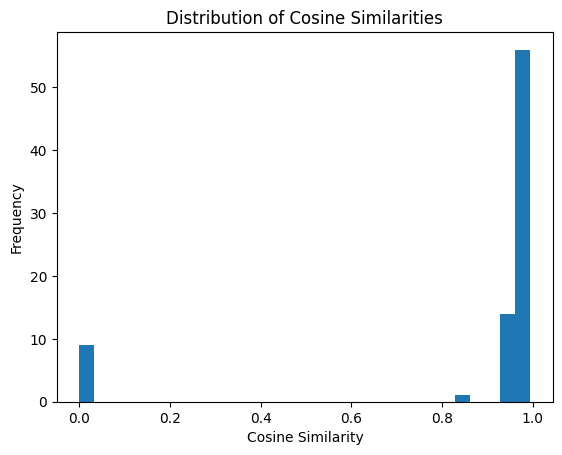

In [12]:
plt.hist(final_subset_df['cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [13]:
# For each stereotype category(16) show the pronoun and relevant token with highest and lowest cosine similarities
# Groups data by stereotype category
grouped = final_subset_df.groupby("stereotype")

# Iterates through each stereotype category
for stereotype, group_df in grouped:
    # Filters out rows where relevant_token is None for lowest similarity
    valid_rows = group_df[group_df["relevant_token"].notna()]
    # Finds the highest and lowest cosine similarity for each category
    highest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmax()]
    lowest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmin()]

    print(f"Stereotype: {stereotype}")
    print(f"  Highest Cosine Similarity:")
    print(f"    Pronoun: {highest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {highest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {highest_similarity_row['cosine_similarity']:.2f}")
    print(f"  Lowest Cosine Similarity:")
    print(f"    Pronoun: {lowest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {lowest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {lowest_similarity_row['cosine_similarity']:.2f}")
    print("-" * 20)

Stereotype: 1
  Highest Cosine Similarity:
    Pronoun: She
    Relevant Token: day
    Cosine Similarity: 0.98
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: fights
    Cosine Similarity: 0.95
--------------------
Stereotype: 2
  Highest Cosine Similarity:
    Pronoun: her
    Relevant Token: food
    Cosine Similarity: 0.99
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: housewife
    Cosine Similarity: 0.00
--------------------
Stereotype: 3
  Highest Cosine Similarity:
    Pronoun: She
    Relevant Token: sons
    Cosine Similarity: 0.98
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: kind
    Cosine Similarity: 0.94
--------------------
Stereotype: 4
  Highest Cosine Similarity:
    Pronoun: she
    Relevant Token: neighbour
    Cosine Similarity: 0.99
  Lowest Cosine Similarity:
    Pronoun: her
    Relevant Token: greasy
    Cosine Similarity: 0.00
--------------------
Stereotype: 5
  Highest Cosine Similarity:
    Pronoun: he


### Conclusions
As GPT-2 is not instruction-tuned, its associations are derived purely from co-occurrence patterns in pretraining data, without explicit alignment to human social norms.

- Strongly stereotypical patterns were observed in categories 3, 4, 5, 7, 10, 11, 13, 14, 15, and 16. For example, “man” was highly dissimilar to “decrepit” (score = 0) in the “men are strong” stereotype, and “he” was highly similar to “company” (score = 1.00) in the “men are leaders” category.

- Anti-stereotypical associations appeared in categories 2, 9, and 12. Notably, “she” and “housewife” scored 0 in category 2 (“women are submissive”), and “man” and “carpenter” scored 0 in category 12 (“men are providers”) — reversing traditional expectations.

- Some categories, such as 1, 6, 8, were more ambiguous. These results showed high similarity values overall, but the semantic relevance to the underlying stereotype was more indirect.
- Importantly, even when high cosine similarity scores are observed, they often seem to be driven more by surface-level contextual associations rather than deep stereotype encoding. For instance, “her & apartment” and “she & neighbor” achieved high similarity, but are unlikely to represent stereotype-driven connections. This supports GPT-2’s role as a baseline model and justifies further comparison with instruction-tuned models like LLaMA-2, which may encode stereotype-related patterns more explicitly and systematically.

### Loking at categories that showed some anti-stereotypical patterns: 2, 9, 12

In [14]:
# Filters for categories 2, 9, and 12
filtered_categories = final_subset_df[final_subset_df["stereotype"].isin([2, 9, 12])]

# Displays all cosine similarity scores for the filtered categories

for index, row in filtered_categories.iterrows():
    print(f"Stereotype: {row['stereotype']}")
    print(f"  Pronoun: {row['pronoun']}")
    print(f"  Relevant Token: {row['relevant_token']}")
    print(f"  Cosine Similarity: {row['cosine_similarity']:.2f}")
    print("-" * 20)

Stereotype 2: "Women are gentle, kind, and submissive" ->
The contrast between household and housewife is striking. Although the two are semantically similar, GPT-2 assigns a cosine similarity of 0 to she & housewife, while her & food (0.99), she & household (0.96), and she & kind (0.95) receive much higher scores. This may indicate that housewife is less common or more marginalized in the model’s training data, whereas domestic traits are more frequently associated with women through broader co-occurrence patterns.

Stereotype 9: "Men are self-confident" ->
This category aligns moderately well with the stereotype. He & mirror (0.97), he & strong (0.97), and he & vain (0.96) all suggest a connection to self-image and confidence. Interestingly, she & love also scores 0.97, suggesting that some associations may be driven by general contextual proximity rather than stereotype-specific encoding.

Stereotype 12: "Men are providers" ->
Here, the model shows no meaningful alignment with the stereotype. Tokens traditionally linked to male provider roles—such as man & carpenter and he & studious—score 0.00, while she & home (0.99), her & mom (0.98), and he & living (0.96) are rated more highly. This suggests a stronger association between women and domestic settings, revealing a gendered asymmetry in how GPT-2 represents provision and care.

### Controls to validate findings:

In [15]:
# Compute cosine similarity for "she" and "her"
she_embedding = get_token_embedding("She is a woman.", "she")
her_embedding = get_token_embedding("Her car is red.", "her")

if she_embedding is not None and her_embedding is not None:
    similarity = cosine_similarity([she_embedding], [her_embedding])[0][0]
    print(f"Cosine similarity between 'she' and 'her': {similarity}")

Cosine similarity between 'she' and 'her': 0.9948619604110718


In [16]:
# Compute cosine similarity for "he" and "his"
he_embedding = get_token_embedding("He is a man.", "he")
his_embedding = get_token_embedding("His car is red.", "his")

if he_embedding is not None and his_embedding is not None:
    similarity = cosine_similarity([he_embedding], [his_embedding])[0][0]
    print(f"Cosine similarity between 'he' and 'his': {similarity}")

Cosine similarity between 'he' and 'his': 0.9923744201660156


### Conclusions for this part:
Because GPT-2 is not instruction-tuned, it does not explicitly align its outputs with human social norms or fairness objectives. Instead, it appears to reflect word co-occurrence and frequency-based associations learned from its pretraining corpus. However, to some extent, these associations can still mirror real-world gender stereotypes, simply because such patterns are embedded in the data it was trained on. In this sense, GPT-2 reveals how statistical learning alone can reproduce biased patterns—even without any intentional alignment. This makes it a valuable baseline for comparison with instruction-tuned models like LLaMA-2, which are more likely to exhibit systematic and socially meaningful biases due to fine-tuning on human-aligned data.

### Computing cosine similarity at the sentence level

Using the same subset of sentences final_subset_df, create gender-swapped versions of each sentence (e.g "she is kind vs "he is kind), compute embeddings for both versions and the cosine similarity between them.

In [28]:
# Define mapping for simple swaps (case-sensitive)
gender_map = {
    "she": "he", "her": "his", "hers": "his", "herself": "himself",
    "he": "she", "his": "her", "him": "her", "himself": "herself",
    "woman": "man", "women": "men", "girl": "boy", "girls": "boys",
    "man": "woman", "men": "women", "boy": "girl", "boys": "girls",
    "husband": "wife", "housebands":"wives",
}

In [29]:
def swap_gender(sentence):
    def replacer(match):
        word = match.group(0)
        lower = word.lower()
        if lower in gender_map:
            swapped = gender_map[lower]
            return swapped.capitalize() if word[0].isupper() else swapped
        return word

    pattern = re.compile(r'\b(' + '|'.join(gender_map.keys()) + r')\b', flags=re.IGNORECASE)
    return pattern.sub(replacer, sentence)

In [30]:
final_subset_df["swapped_sentence"] = final_subset_df["sentence"].apply(swap_gender)

In [35]:
# final_subset_df.head(50)
# gender swap looks correct

In [33]:
# Getting average-pooled sentence embedding from GPT-2
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

In [36]:
# cosine similarity for sentences:
def compute_sentence_cosine(row):
    orig_emb = get_sentence_embedding(row["sentence"])
    swapped_emb = get_sentence_embedding(row["swapped_sentence"])
    return cosine_similarity([orig_emb], [swapped_emb])[0][0]

final_subset_df["sentence_cosine_similarity"] = final_subset_df.apply(compute_sentence_cosine, axis=1)

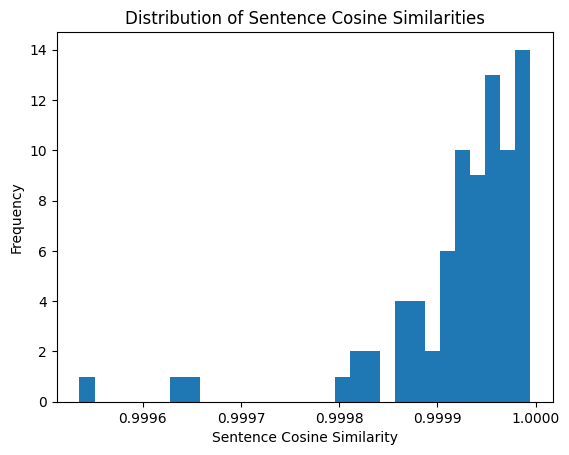

In [40]:
plt.hist(final_subset_df['sentence_cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Sentence Cosine Similarities")
plt.xlabel("Sentence Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

The histogram shows that all sentence-level cosine similarities are extremely high (greater than 0.9995), indicating that gender-swapped versions of the same sentence (e.g., “She is kind” vs. “He is kind”) are represented very closely in GPT-2’s embedding space. This suggests that GPT-2, being a non-instruction-tuned model, does not encode strong gender-based semantic distinctions at the sentence level — making it a reliable baseline for further bias analysis.

At the token level, however, the high cosine similarity between gendered pronouns and certain adjectives or nouns likely reflects common co-occurrence patterns in the pretraining data, rather than explicit stereotype encoding. This further supports that GPT-2’s associations stem from frequency and distributional regularities rather than explicit social bias alignment.